In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)

from utils.config import *

from src.adjustcls import *
from src.adjustl1 import *
from src.decomposer import *
from utils.loadsimulation import *
from utils.moments import *
from utils.image import *

import matplotlib.pyplot as plt
# Set global rc parameters for plot appearance
plt.rcParams.update({
    'axes.titlesize': 12,            # Font size for the plot titles
    'axes.labelsize': 12,            # Font size for the x and y labels
    'legend.fontsize': 12,           # Font size for the legend
    'xtick.labelsize': 12,           # Font size for the x-tick labels
    'ytick.labelsize': 12,           # Font size for the y-tick labels
    'axes.linewidth': 2.,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 12,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

from scipy import stats
import math

import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import CubicSpline
import numpy as np


Project root added to sys.path: /feynman/work/dap/lcs/vt272285/Generative modelling of convergence map
Global imports loaded successfully!


The number of scales is:  5
the target pixelsize is:  0.3097573567372225
the target size is:  (1024, 1024)
The number of scales is:  5
 Iteration: 151 Scale: 5

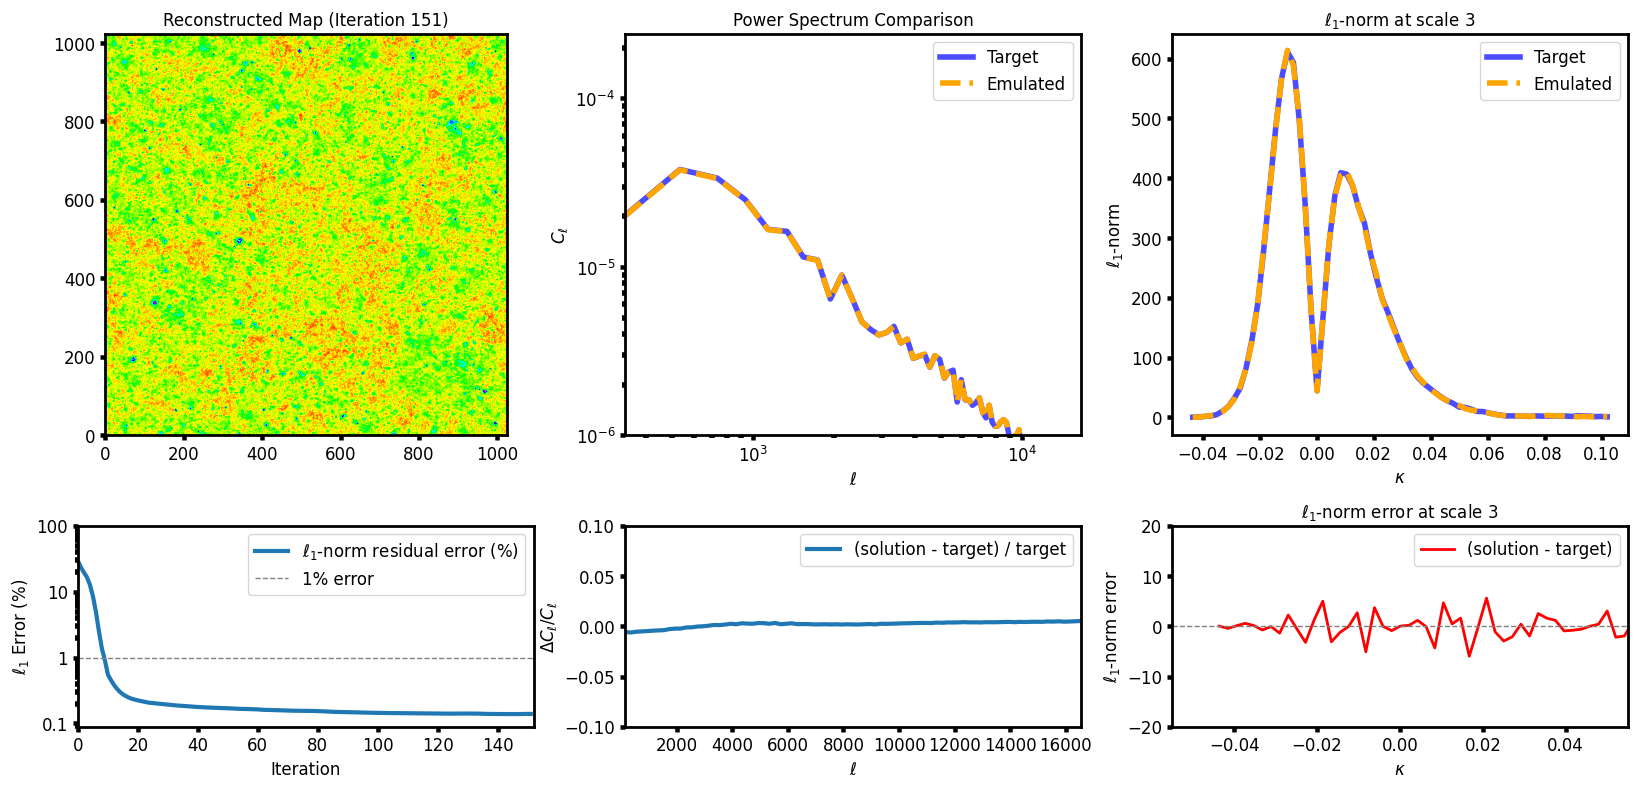

In [15]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
filter_type = 'tophat'
nscales = 5
print("The number of scales is: ", nscales)
nbins = [71]*(nscales+1)
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

decomposer = WaveletDecomposer()
density = False
target_values = process_image(target, filter_type, nscales, nbins, decomposer, density=density)

# seed = 10
# np.random.seed(seed)
gaussian = np.random.normal(0., np.std(target), target.shape)

pkadjuster = PowerSpectrum(gaussian, pixelsize)
solution = gaussian

total_error = []

# Store image snapshots and errors
image_snapshots = []
cls_snapshots = []
l1_snapshots = []

# Create figure and GridSpec
fig = plt.figure(figsize=(20, 9))
# gs = GridSpec(2, 3, width_ratios=[3, 2], height_ratios=[2, 1], hspace=0.3)
gs = GridSpec(
    2, 3, 
    width_ratios=[2, 2, 2],  # Now matches the 3 columns
    height_ratios=[2, 1], 
    hspace=0.3
)
# Left column: Map (top) and error (bottom)
ax_map = fig.add_subplot(gs[0, 0])
im = ax_map.imshow(np.zeros_like(solution), cmap='hsv', origin='lower',vmin=-0.1, vmax=0.4)
ax_map.set_title("Reconstructed Map (Iteration 0)")
# plt.colorbar(im, ax=ax_map)

ax_err = fig.add_subplot(gs[1, 0])
error_line, = ax_err.plot([], [], label=r"$\ell_1$-norm residual error (%)")
ax_err.axhline(1, color='grey', linestyle='--', linewidth=1, label="1% error")
ax_err.set_yscale('log')
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax_err.yaxis.set_major_formatter(formatter)
yticks = [0.1, 1, 10, 100]
ax_err.set_yticks(yticks)
ax_err.set_yticklabels([str(int(t)) if t >= 1 else str(t) for t in yticks])
ax_err.set_xlabel("Iteration")
ax_err.set_ylabel(r"$\ell_1$ Error (%)")
ax_err.legend()

# Right column: Power spectrum and fractional error
ax_cl = fig.add_subplot(gs[0, 1])
ax_cl.set_xscale('log')
ax_cl.set_yscale('log')
ax_cl.set_title('Power Spectrum Comparison')
ax_cl.set_xlabel(r'$\ell$')
ax_cl.set_ylabel(r'$C_\ell$')
line_target_cl, = ax_cl.plot(target_ells[1:], target_cls[1:], label='Target', lw=4, c='blue', alpha=0.7)
line_solution_cl, = ax_cl.plot([], [], label='Emulated', c='orange', ls='--', lw=4)
ax_cl.legend()

ax_frac = fig.add_subplot(gs[1, 1])
ax_frac.set_ylim(-0.1, 0.1)
ax_frac.set_xlabel(r'$\ell$')
ax_frac.set_ylabel(r'$\Delta C_\ell / C_\ell$')
line_frac, = ax_frac.plot([], [], label='(solution - target) / target')
ax_frac.legend()

ax_l1 = fig.add_subplot(gs[0, 2])
ax_l1.set_title(r'$\ell_1$-norm at scale 3')
ax_l1.set_xlabel(r'$\kappa$')
ax_l1.set_ylabel(r'$\ell_1$-norm')
# Initialize the plot with the first image
edges_target = target_values[f'scale_{3}']['binedges']
centers_target = target_values[f'scale_{3}']['bincenters']
l1_target = target_values[f'scale_{3}']['l1_norm']
    
line_l1_target, = ax_l1.plot(centers_target,l1_target, label='Target', lw=4, c='blue', alpha=0.7)
line_l1_solution, = ax_l1.plot([], [], label='Emulated', c='orange', ls='--', lw=4)
ax_l1.legend()

ax_l1_err = fig.add_subplot(gs[1, 2])
ax_l1_err.set_title(r'$\ell_1$-norm error at scale 3')
ax_l1_err.set_xlabel(r'$\kappa$')
ax_l1_err.set_ylabel(r'$\ell_1$-norm error')
l1_error_line, = ax_l1_err.plot([], [], lw=2, c='red', label='(solution - target)')
ax_l1_err.axhline(0, color='grey', linestyle='--', linewidth=1)
ax_l1_err.set_ylim(-20,20)
ax_l1_err.legend()

# Main loop to populate data
print("The number of scales is: ", nscales)
for iter in range(152):
    image_snapshots.append(solution.copy())
    # Compute and store Cls
    _, solutionells, solutioncls = pkadjuster.calculate_Cls(solution)
    if iter == 0:
        solutioncls = solutioncls * (target_cls[0] / solutioncls[0])  # Normalize to match target_cls[0]
    cls_snapshots.append((solutionells.copy(), solutioncls.copy()))
    
    # plt.figure()
    # plt.loglog(solutionells[1:], solutioncls[1:], label='Emulated', c='orange', ls='--', lw=4)
    # plt.show()
    solution_coefs = decomposer.decompose(solution, num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(
        solution_coefs[3], mask=None, nbins=edges_target, density=density)
    l1_snapshots.append((solution_centers.copy(), solution_l1norm.copy()))
    error_per_scale = 0.
    for scale in range(nscales + 1):
        print(f"\r Iteration: {iter} Scale: {scale}", end="", flush=True)
        solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density)
        error_per_scale += err

    total_error.append(error_per_scale)
    solution_l1 = np.sum(solution_coefs, axis=0)

    if iter % 1 == 0:
        solution_cl_map = pkadjuster.generate_field_with_target_cls(solution, target_cls, target_ells)
        solution = 0.5 * (solution_cl_map + solution_l1)
    else:
        solution = solution_l1

    solution = np.clip(solution, np.min(target), np.max(target))

# Animation update function
def update(frame):
    im.set_data(image_snapshots[frame])
    ax_map.set_title(f"Reconstructed Map (Iteration {frame})")

    error_line.set_data(np.arange(frame + 1), np.array(total_error[:frame + 1]) * 100)
    ax_err.set_xlim(0, len(total_error))

    # Update Cls
    solutionells, solutioncls = cls_snapshots[frame-1]
    line_solution_cl.set_data(solutionells[1:], solutioncls[1:])

    # Fractional diff
    solution_cls_spline = CubicSpline(solutionells, solutioncls)
    delta_cl = (solution_cls_spline(target_ells) - target_cls) / target_cls
    line_frac.set_data(target_ells, delta_cl)

    solutionkappa, solutionl1 = l1_snapshots[frame-1]
    line_l1_solution.set_data(solutionkappa, solutionl1)
    
    residual_l1 = solutionl1 - l1_target
    l1_error_line.set_data(solutionkappa, residual_l1)
    
    
    ax_cl.set_xlim(min(target_ells[1:]), max(target_ells[1:]))
    ax_cl.set_ylim(1e-6, max(target_cls) * 2)

    ax_frac.set_xlim(min(target_ells), max(target_ells))
    
    return [im, error_line, line_solution_cl, line_frac, line_l1_target, l1_error_line]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(image_snapshots), interval=100, blit=True)

# Save or display
ani.save("solution_animation.gif", writer='pillow', fps=5)
# from IPython.display import HTML
# HTML(ani.to_jshtml())
